In [1]:
%load_ext autoreload
%autoreload 2
# %autoreload # reloads modules
# %aimport # lists what it will/won't reload

import os
import numpy as np
import pandas as pd

import nltk

from utils import *

import matplotlib.pyplot as plt
from IPython.display import IFrame, display

pd.options.display.max_columns = None

### Read

In [2]:
filenames = ["data/articles{}.csv".format(n) for n in [1,2,3]]

In [3]:
# df = pd.read_csv(file[0], encoding='utf-8')
df = pd.concat([pd.read_csv(file, encoding='utf-8') for file in filenames], ignore_index=True)
df.drop(columns=['Unnamed: 0'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142570 entries, 0 to 142569
Data columns (total 10 columns):
Unnamed: 0     142570 non-null int64
id             142570 non-null int64
title          142568 non-null object
publication    142570 non-null object
author         126694 non-null object
date           139929 non-null object
year           139929 non-null float64
month          139929 non-null float64
url            85559 non-null object
content        142570 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 10.9+ MB


In [4]:
df.year.value_counts()

2016.0    85405
2017.0    50404
2015.0     3705
2013.0      228
2014.0      125
2012.0       34
2011.0        8
2010.0        6
2009.0        3
2008.0        3
2005.0        2
2004.0        2
2003.0        2
2007.0        1
2000.0        1
Name: year, dtype: int64

In [5]:
df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [6]:
df.publication.value_counts()

Breitbart              23781
New York Post          17493
NPR                    11992
CNN                    11488
Washington Post        11114
Reuters                10710
Guardian                8681
New York Times          7803
Atlantic                7179
Business Insider        6757
National Review         6203
Talking Points Memo     5214
Vox                     4947
Buzzfeed News           4854
Fox News                4354
Name: publication, dtype: int64

#### Wow that feels like a strange skew towards Breitbart (perhaps because they are more prolific?). Will have to keep this in mind whenever considering relative frequencies
> Should I remove some Breitbart stuff to reduce influence of a barely-news news source?

### Gather and preprocess text

In [7]:
# Some acronyms are messed up -- maybe just do to strings you plan to analyze??
# one to try: df[df.id == 20550].content.values
fix_acronyms = lambda x: x.group(0).replace(' ', '') + ' '
find_replace_acronyms = lambda c: re.sub(r'(?:\w\. ){2,}', fix_acronyms, c)
df['content'] = df.content.apply(find_replace_acronyms)

In [8]:
# remove rows with null dates, use date objects, and add day column to help filter
df.drop(df.index[df.date.isnull()], inplace=True)
df['date'] = df.date.apply(lambda x: x.replace('/', '-'))
df['date'] = pd.to_datetime(df.date)
df['day'] = df.date.map(lambda x: x.day)

#### First we need stories from an islamic shooter
Lets try to "find" the two orlando stories now using cosine similarity of TFIDF vectors

In [9]:
orlando_date = (12, 6, 2016)

df_after_or = get_events_daterange(df, orlando_date)

In [10]:
stories_after_or = df_to_stringlist(df_after_or)
similarity_after_or = get_cosine_similarity(stories_after_or)

Calculating cosine similarity using tfidf: max_df=0.95, min_df=2
TFIDF vectorization complete. Calculating cosine similarity...


Find similarity to a known orlando story. Here are two such stories--happened 2 and 4 days after the shooting.

In [11]:
# orlando shooting happened on 6/12/2016
df[df.id.isin([20547, 20550])]

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
2941,2941,20547,"Orlando Gunman Attacks Gay Nightclub, Leaving ...",New York Times,Lizette Alvarez and Richard Pérez-Peña,2016-06-14,2016.0,6.0,NaN,"ORLANDO, Fla. — A man who called 911 to pro...",14
2943,2943,20550,Orlando Shooting: What We Know and Don’t Know ...,New York Times,Liam Stack,2016-06-16,2016.0,6.0,NaN,A gunman who claimed allegiance to the Islamic...,16


,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
2943,2943,20550,Orlando Shooting: What We Know and Don’t Know ...,New York Times,Liam Stack,2016-06-16,2016.0,6.0,NaN,A gunman who claimed allegiance to the Islamic...,16


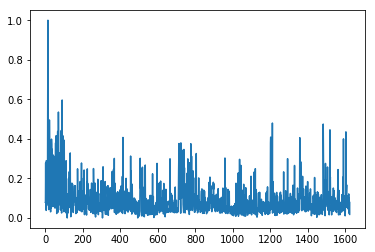

In [12]:
or_idx = get_idx_from_id(df_after_or, 20550)

# display to be sure
display(df_after_or.iloc[or_idx:or_idx+1])

plt.plot(similarity_after_or[or_idx])
plt.show()

In [13]:
# get likely stories now
likely_or = get_similar_by_daterange_sid(df, date=orlando_date, sid=20550, n_most_similar=30)
likely_or

Getting stories within 7 days of 6/12/2016 (within the same month)
Processing stories...
Calculating cosine similarity using tfidf: max_df=0.95, min_df=2
TFIDF vectorization complete. Calculating cosine similarity...


,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
2943,2943,20550,Orlando Shooting: What We Know and Don’t Know ...,New York Times,Liam Stack,2016-06-16,2016.0,6.0,NaN,A gunman who claimed allegiance to the Islamic...,16
6620,6620,24948,Omar Mateen Posted to Facebook Amid Orlando At...,New York Times,"Alan Blinder, Frances Robles and Richard Pérez...",2016-06-17,2016.0,6.0,NaN,"JENSEN BEACH, Fla. — The gunman who committ...",17
5410,5410,23326,Omar Mateen Told Police He’d Strap Bombs to Ho...,New York Times,Frances Robles and Richard Pérez-Peña,2016-06-17,2016.0,6.0,NaN,"ORLANDO, Fla. — Amid the massacre at a gay ...",17
2941,2941,20547,"Orlando Gunman Attacks Gay Nightclub, Leaving ...",New York Times,Lizette Alvarez and Richard Pérez-Peña,2016-06-14,2016.0,6.0,NaN,"ORLANDO, Fla. — A man who called 911 to pro...",14
2955,2955,20563,Obama Says Orlando Gunman Was Probably a Homeg...,New York Times,Julie Hirschfeld Davis,2016-06-14,2016.0,6.0,NaN,WASHINGTON — President Obama said Monday th...,14
111410,114873,169930,Orlando’s Deadly Mass Shooting: What We Know M...,NPR,Bill Chappell,2016-06-13,2016.0,6.0,http://www.npr.org/sections/thetwo-way/2016/06...,"One day after a depraved attack on an Orlando,...",13
138342,141805,212708,Gunman in Orlando pledged allegiance to ISIS; ...,Washington Post,Hayley Tsukayama,2016-06-12,2016.0,6.0,https://web.archive.org/web/20160613001042/htt...,ORLANDO — The gunman who opened fire...,12
138379,141842,212763,FBI says Orlando gunman had been on watchlist;...,Washington Post,Matt Zapotosky,2016-06-14,2016.0,6.0,https://web.archive.org/web/20160615002545/htt...,ORLANDO — Investigators from the FBI...,14
6613,6613,24941,Obama Denounces Donald Trump for His ‘Dangerou...,New York Times,Julie Hirschfeld Davis and Matt Flegenheimer,2016-06-15,2016.0,6.0,NaN,WASHINGTON — President Obama angrily denoun...,15
5404,5404,23320,"After F.B.I.’s Inquiry Into Omar Mateen, a Foc...",New York Times,Matt Apuzzo and Eric Lichtblau,2016-06-15,2016.0,6.0,NaN,"WASHINGTON — Every day, in F.B.I. offices a...",15


Wow! This actually worked super super well

Calculating cosine similarity using tfidf: max_df=1.0, min_df=1
TFIDF vectorization complete. Calculating cosine similarity...
30


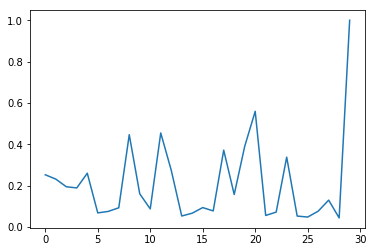

In [14]:
# likely_or[likely_or.id == 26201].content.iloc[0]
cs = get_cosine_similarity(df_to_stringlist(likely_or), max_df=1.0, min_df=1)
print(len(likely_or))
plt.plot(cs[get_idx_from_id(likely_or, 20551)]) # an unrelated story
plt.show()

In [15]:
stories_or, ignored = kmeans_split(likely_or, order_by_sid=20550)

print('ignored stories:')
ignored

ignored stories:


,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
138464,141927,212866,Troubled. Quiet. Macho. Angry. The volatile li...,Washington Post,Kevin Sullivan,2016-06-17,2016.0,6.0,https://web.archive.org/web/20160619005138/htt...,After a lifetime of angst and embarra...,17


Definite improvement, but for the sake of clean data lets pull out the last two unrelated stories

In [16]:
to_remove = [5396,7555]
if np.any([stories_or.index.contains(i) for i in to_remove]):
    stories_or = stories_or.drop(to_remove)

stories_or

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
2943,2943,20550,Orlando Shooting: What We Know and Don’t Know ...,New York Times,Liam Stack,2016-06-16,2016.0,6.0,NaN,A gunman who claimed allegiance to the Islamic...,16
6620,6620,24948,Omar Mateen Posted to Facebook Amid Orlando At...,New York Times,"Alan Blinder, Frances Robles and Richard Pérez...",2016-06-17,2016.0,6.0,NaN,"JENSEN BEACH, Fla. — The gunman who committ...",17
5410,5410,23326,Omar Mateen Told Police He’d Strap Bombs to Ho...,New York Times,Frances Robles and Richard Pérez-Peña,2016-06-17,2016.0,6.0,NaN,"ORLANDO, Fla. — Amid the massacre at a gay ...",17
2941,2941,20547,"Orlando Gunman Attacks Gay Nightclub, Leaving ...",New York Times,Lizette Alvarez and Richard Pérez-Peña,2016-06-14,2016.0,6.0,NaN,"ORLANDO, Fla. — A man who called 911 to pro...",14
2955,2955,20563,Obama Says Orlando Gunman Was Probably a Homeg...,New York Times,Julie Hirschfeld Davis,2016-06-14,2016.0,6.0,NaN,WASHINGTON — President Obama said Monday th...,14
111410,114873,169930,Orlando’s Deadly Mass Shooting: What We Know M...,NPR,Bill Chappell,2016-06-13,2016.0,6.0,http://www.npr.org/sections/thetwo-way/2016/06...,"One day after a depraved attack on an Orlando,...",13
138342,141805,212708,Gunman in Orlando pledged allegiance to ISIS; ...,Washington Post,Hayley Tsukayama,2016-06-12,2016.0,6.0,https://web.archive.org/web/20160613001042/htt...,ORLANDO — The gunman who opened fire...,12
138379,141842,212763,FBI says Orlando gunman had been on watchlist;...,Washington Post,Matt Zapotosky,2016-06-14,2016.0,6.0,https://web.archive.org/web/20160615002545/htt...,ORLANDO — Investigators from the FBI...,14
6613,6613,24941,Obama Denounces Donald Trump for His ‘Dangerou...,New York Times,Julie Hirschfeld Davis and Matt Flegenheimer,2016-06-15,2016.0,6.0,NaN,WASHINGTON — President Obama angrily denoun...,15
5404,5404,23320,"After F.B.I.’s Inquiry Into Omar Mateen, a Foc...",New York Times,Matt Apuzzo and Eric Lichtblau,2016-06-15,2016.0,6.0,NaN,"WASHINGTON — Every day, in F.B.I. offices a...",15


In [17]:
len(stories_or)

29

Great....

#### Now we need stories from a shooting with a non-islamic-extremist
Lets use the Dallas police shooting on 7/7/2016

In [18]:
dallas_date = (7,7,2016)

stories_after_dallas = get_events_daterange(df, dallas_date)
cs_dal = get_cosine_similarity(stories_after_dallas)

Converting dataframe to stringlist
Calculating cosine similarity using tfidf: max_df=0.95, min_df=2
TFIDF vectorization complete. Calculating cosine similarity...


In [19]:
dal_idxs = np.where(stories_after_dallas.title.str.contains('Shooter'))[0]
stories_after_dallas.iloc[dal_idxs]

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
23043,23047,41795,Dallas Shooter Micah Xavier Johnson Wanted To ...,Breitbart,Michelle Moons,2016-07-08,2016.0,7.0,NaN,One suspect in the assassinations and attacks ...,8
26859,26865,45620,Confirmed: Dallas Shooter Was Member of Housto...,Breitbart,Bob Price,2016-07-08,2016.0,7.0,NaN,"HOUSTON, Texas — Micah X. Johnson was a mem...",8
28472,28480,47241,Obama: ’Very Hard To Untangle the Motives’ Of ...,Breitbart,Ian Hanchett,2016-07-09,2016.0,7.0,NaN,"During a speech in Warsaw, Poland on Saturday,...",9
36194,37082,55912,Dallas police chief: Shooter had larger plans,CNN,Eric Bradner,2016-07-10,2016.0,7.0,NaN,(CNN) The gunman who killed five police offic...,10
36212,37104,55934,"USA delays ’Shooter’ premiere, again, in wake ...",CNN,NaN,2016-07-11,2016.0,7.0,NaN,(CNN) USA Network has once again delayed the ...,11
111959,115422,170610,"Amid Deepening Investigation, A Clearer Pictur...",NPR,Dina Temple-Raston,2016-07-10,2016.0,7.0,http://www.npr.org/sections/thetwo-way/2016/07...,The man who fatally shot five police officers ...,10
138934,142397,213454,Dallas police chief: Shooter seemed delusional...,Washington Post,William Branigin,2016-07-10,2016.0,7.0,https://web.archive.org/web/20160711001900/htt...,The gunman who fatally shot five Dallas law e...,10


Ugh many Breitbart race baiting articles... use 55912

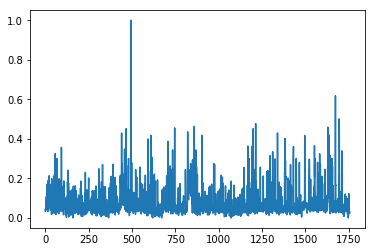

In [20]:
best_story_id = 55912
plt.plot(cs_dal[get_idx_from_id(stories_after_dallas, best_story_id)])
plt.show()

In [21]:
likely_dal = get_similar_by_daterange_sid(df, dallas_date, best_story_id, 30)
likely_dal

Getting stories within 7 days of 7/7/2016 (within the same month)
Processing stories...
Calculating cosine similarity using tfidf: max_df=0.95, min_df=2
TFIDF vectorization complete. Calculating cosine similarity...


,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
36194,37082,55912,Dallas police chief: Shooter had larger plans,CNN,Eric Bradner,2016-07-10,2016.0,7.0,NaN,(CNN) The gunman who killed five police offic...,10
138934,142397,213454,Dallas police chief: Shooter seemed delusional...,Washington Post,William Branigin,2016-07-10,2016.0,7.0,https://web.archive.org/web/20160711001900/htt...,The gunman who fatally shot five Dallas law e...,10
138957,142420,213481,Dallas police chief says ‘we’re asking cops to...,Washington Post,Brady Dennis,2016-07-11,2016.0,7.0,https://web.archive.org/web/20160712002005/htt...,DALLAS — The police chief here said ...,11
99902,103361,151785,Details of Dallas gunman’s larger plans emerge...,Guardian,Jon Swaine,2016-07-10,2016.0,7.0,https://www.theguardian.com/us-news/2016/jul/1...,Hundreds of demonstrators were arrested in cit...,10
59173,62492,85055,Dallas’ top cop has answer for protesters: Joi...,Fox News,NaN,2016-07-11,2016.0,7.0,https://web.archive.org/web/20160712015808/htt...,Only days after watching five of his officers...,11
138889,142352,213401,Dallas police shooting kills five officers; gu...,Washington Post,Tim Madigan,2016-07-08,2016.0,7.0,https://web.archive.org/web/20160709002000/htt...,DALLAS — Five Dallas police officers...,8
54230,57540,79000,Dallas Police Chief: ’We’re All on Edge’,Atlantic,Marina Koren,2016-07-11,2016.0,7.0,NaN,I want to receive updates from partners and...,11
94939,98398,145292,Dallas police chief asks protesters to join cops,New York Post,Kate Sheehy,2016-07-11,2016.0,7.0,http://nypost.com/2016/07/11/dallas-police-chi...,Dallas’s police chief revealed chilling new de...,11
36166,37052,55882,Dallas police chief’s storied career marked by...,CNN,Holly Yan,2016-07-09,2016.0,7.0,NaN,"(CNN) In his six years as police chief, David...",9
59135,62454,85011,Dallas sniper who gunned down 5 cops ’wanted t...,Fox News,NaN,2016-07-08,2016.0,7.0,https://web.archive.org/web/20160709001738/htt...,Five Dallas police officers were killed and s...,8


In [22]:
likely_dal.publication.value_counts()

Washington Post     6
CNN                 4
Atlantic            3
New York Post       3
Fox News            3
Guardian            3
Reuters             2
Business Insider    2
NPR                 2
Breitbart           1
Buzzfeed News       1
Name: publication, dtype: int64

Let's try to remove some of the unrelated stories again. I see more analysis pieces and some police shooting pieces as well, so likely a tougher job

In [23]:
stories_dal, ignored = kmeans_split(likely_dal, order_by_sid=55912)

print('ignored stories:')
ignored

ignored stories:


,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
138957,142420,213481,Dallas police chief says ‘we’re asking cops to...,Washington Post,Brady Dennis,2016-07-11,2016.0,7.0,https://web.archive.org/web/20160712002005/htt...,DALLAS — The police chief here said ...,11
138889,142352,213401,Dallas police shooting kills five officers; gu...,Washington Post,Tim Madigan,2016-07-08,2016.0,7.0,https://web.archive.org/web/20160709002000/htt...,DALLAS — Five Dallas police officers...,8
36140,37020,55850,"Dallas shooting: 5 officers die, suspect ID’d",CNN,Faith Karimi,2016-07-08,2016.0,7.0,NaN,(CNN) The ambush started with gunshots that k...,8
69848,73256,108994,12 Officers Shot By Sniper Fire At Dallas Pro...,Buzzfeed News,Salvador Hernandez,2016-07-08,2016.0,7.0,https://web.archive.org/web/20160708150131/htt...,’Twelve Texas police officers were shot by sni...,8
111924,115387,170562,Ambush In Dallas: What We Know Friday,NPR,Camila Domonoske,2016-07-08,2016.0,7.0,http://www.npr.org/sections/thetwo-way/2016/07...,This is a developing story. Last updated 7:23 ...,8
54191,57501,78937,The Dallas Shootings: What We Know,Atlantic,Matt Ford,2016-07-08,2016.0,7.0,NaN,", I want to receive updates from partners and ...",8
36157,37040,55870,Dallas police end search for suspicious person,CNN,NaN,2016-07-09,2016.0,7.0,NaN,(CNN) Dallas police officers searched for hou...,9
138972,142435,213503,Obama speaks at Dallas memorial service honori...,Washington Post,Keith L. Alexander,2016-07-12,2016.0,7.0,https://web.archive.org/web/20160713001012/htt...,DALLAS — President Obama sought to u...,12


K-means didn't do so well getting rid of the right stories this time....... Will proceed manually for now!

In [24]:
stories_dal = stories_dal[stories_dal.content.str.contains('Micah')]
print(len(stories_dal))
stories_dal

14


,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
36194,37082,55912,Dallas police chief: Shooter had larger plans,CNN,Eric Bradner,2016-07-10,2016.0,7.0,NaN,(CNN) The gunman who killed five police offic...,10
138934,142397,213454,Dallas police chief: Shooter seemed delusional...,Washington Post,William Branigin,2016-07-10,2016.0,7.0,https://web.archive.org/web/20160711001900/htt...,The gunman who fatally shot five Dallas law e...,10
99902,103361,151785,Details of Dallas gunman’s larger plans emerge...,Guardian,Jon Swaine,2016-07-10,2016.0,7.0,https://www.theguardian.com/us-news/2016/jul/1...,Hundreds of demonstrators were arrested in cit...,10
59173,62492,85055,Dallas’ top cop has answer for protesters: Joi...,Fox News,NaN,2016-07-11,2016.0,7.0,https://web.archive.org/web/20160712015808/htt...,Only days after watching five of his officers...,11
54230,57540,79000,Dallas Police Chief: ’We’re All on Edge’,Atlantic,Marina Koren,2016-07-11,2016.0,7.0,NaN,I want to receive updates from partners and...,11
103636,107096,158065,Dallas police chief David Brown: veteran of tr...,Guardian,Matthew Teague,2016-07-13,2016.0,7.0,https://www.theguardian.com/us-news/2016/jul/1...,There’s a paradox in the way Dallas police chi...,13
123569,127032,189884,"Dallas sniper plotted bigger assault, taunted ...",Reuters,Brian Thevenot and Erwin Seba,2016-07-11,2016.0,7.0,http://www.reuters.com/article/us-minnesota-po...,The U.S. military veteran who fatally shot fi...,11
47647,50777,70510,Texas officials confirm Dallas police shooter ...,Business Insider,Natasha Bertrand,2016-07-09,2016.0,7.0,NaN,’ ’ ’ Texas state officials confirmed that ...,9
123625,127088,189981,Dallas police chief says armed civilians in Te...,Reuters,Ernest Scheyder,2016-07-12,2016.0,7.0,http://www.reuters.com/article/us-usa-police-p...,The Dallas police chief stepped into America’...,12
94397,97856,144498,"Dallas sniper identified, wanted to ‘kill whites’",New York Post,"Yaron Steinbuch, Daniel Halper and Jamie Schram",2016-07-08,2016.0,7.0,http://nypost.com/2016/07/08/cops-used-robot-b...,The who was killed by a robot in Dallas ap...,8


## Analysis

#### Investigation: taking a corpus from each of two shooting events, one with a muslim extremist shooter and one not, how do frequent words compare?
What about the word "terrorist" (absolute or relative to # of words/adjectives in the story)?

In [25]:
print(stories_dal.shape)
print(stories_or.shape)

(14, 11)
(29, 11)


Excellent, we now have two samples of comparative size

In [26]:
# # some words to consider
# terror_vocab  = ['terror', 'terrorist', 'terrorism', 'counterterrorism', 'isi', 'isis', 'isil', 'jihadi', 'jihadis', 'jihadism', 'jihadist', 'islamic', 'extremist', 'radical', 'radicalization', 'radicalized']
# gun_vocab     = ['gun', 'handgun', 'rifle', 'pistol']
# illness_vocab = ['unstable', 'troubled']
# other_vocab   = ['dead', 'killed', 'shooter', 'gunman', 'shooting', 'gunfire', 'mourning']
# unigram_vocab = terror_vocab + gun_vocab + illness_vocab + other_vocab
# # some bigrams to consider
# bi_terror_vocab  = ['terrorist attack', 'muslim extremist', 'islamic extremist', 'islamic state']
# bi_gun_vocab     = ['second amendment']
# bi_illness_vocab = ['mental illness']
# bi_other_vocab   = ['thoughts and prayers', 'al qaeda']
# bigram_vocab     = bi_terror_vocab + bi_gun_vocab + bi_other_vocab

# illness_all = illness_vocab + bi_illness_vocab
# terror_all  = terror_vocab + bi_terror_vocab
# guns_all    = gun_vocab + bi_gun_vocab
# other_all   = other_vocab + bi_other_vocab

In [27]:
# def count_bigrams_as_df(df, vocab=None):
#     docs = df_to_stringlist(df)
#     tf_vectorizer = CountVectorizer(tokenizer=tokenize, ngram_range=(1,2), vocabulary=vocab)
#     tf = tf_vectorizer.fit_transform(docs)
#     return vec_output_to_df(tf_vectorizer, tf)

# # count_bigrams_as_df(stories_dal, guns_all)
# count_bigrams_as_df(stories_or, guns_all)
# # stories_dal.iloc[13].content

Top words counts for stories from each event, using whole year corpus. Also using just the two-event corpus

In [28]:
corpus_2016 = df[df.year == 2016]
corpus_shootings = pd.concat([stories_or, stories_dal])

In [47]:
def get_top_words(corpus, sid, n=20, max_df=0.95, min_df=2, method='tfidf', tokenizer=tokenize, verbose=False):
    print('Get top words in story {}'.format(sid)) if verbose else None
    idx = get_idx_from_id(corpus, sid)
    
    print('Build vectorizer') if verbose else None
    if method == 'tfidf':
        vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_df=max_df, min_df=min_df)
        print('Preprocess corpus') if verbose else None
        docs = df_to_stringlist(corpus)
        print('Fit/transform') if verbose else None
        output = vectorizer.fit_transform(docs)
    else: # note corpus doesn't really matter if you aren't using tfidf
        vectorizer = CountVectorizer(tokenizer=tokenizer, max_df=max_df, min_df=min_df)
        output = vectorizer.fit_transform(df_to_stringlist(corpus))

    print('Convert to a readable dataframe') if verbose else None
    labelled_counts = vec_output_to_df(vectorizer, output)
    print('Get top words') if verbose else None
    return get_top_by_idx(labelled_counts, idx, n=n)

#### Using shooting story corpus

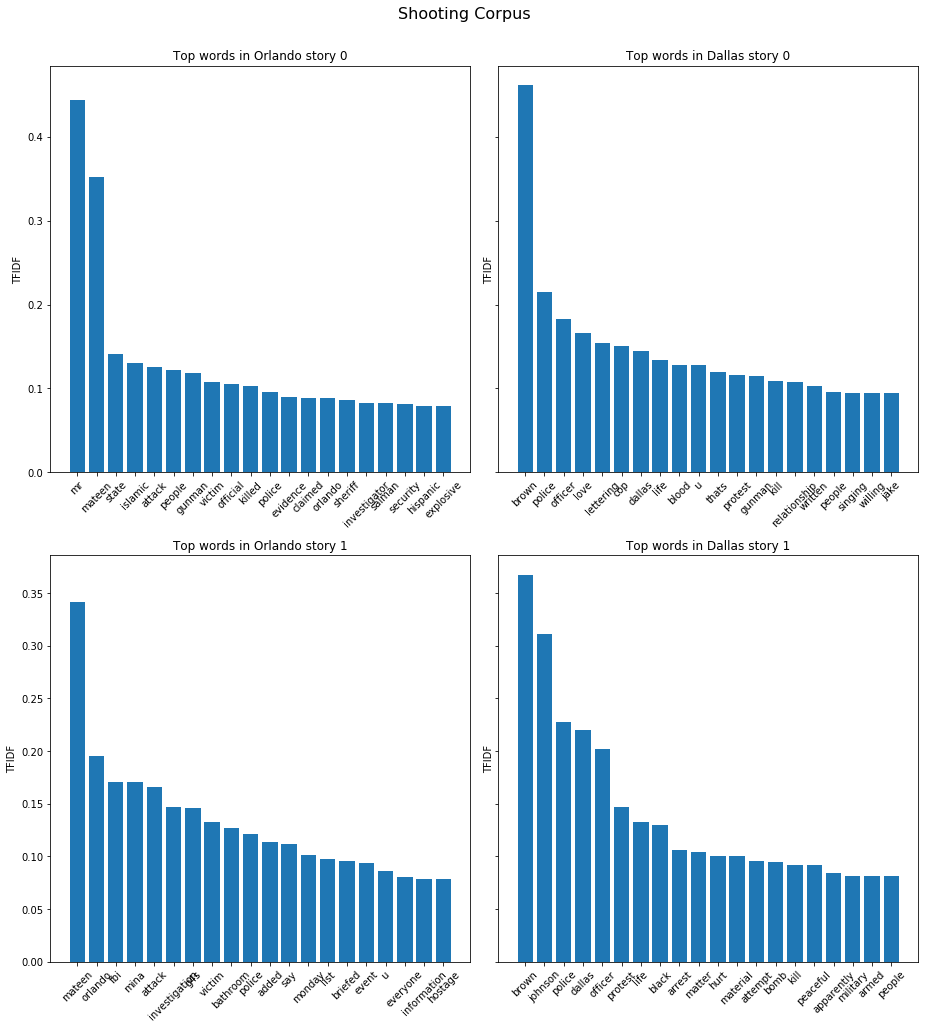

In [51]:
orlando_sids = [20550, 169930] # 20547
dallas_sids = [55912, 213454] # 213402

tokenizer = tokenize
corpus = corpus_shootings

def get_plot_top_words(corpus, tokenizer, all_sids, verbose=False):
    top_words = {}

    nsids = len(all_sids[0])
    fig, axarr = plt.subplots(nsids,2,sharey='row', figsize=(13,15))

    for i ,sid in enumerate(all_sids[0]):
        top_counts = get_top_words(corpus, sid, tokenizer=tokenizer, verbose=verbose)
        top_words[sid] = top_counts
        ax = make_series_bar(axarr.flatten(order='F')[i], 
                             series=top_counts, title='Top words in Orlando story {}'.format(i))
        ax.set_ylabel('TFIDF')

    offset = len(orlando_sids)
    for i ,sid in enumerate(all_sids[1]):
        top_counts = get_top_words(corpus, sid, tokenizer=tokenizer, verbose=verbose)
        top_words[sid] = top_counts
        ax = make_series_bar(axarr.flatten(order='F')[offset + i], 
                             series=top_counts, title='Top words in Dallas story {}'.format(i))
        ax.set_ylabel('TFIDF')

    # plt.savefig('compare_orlando_tfidf_scores.png')
    plt.suptitle('Shooting Corpus', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return top_words

top_words_corpus_shootings = get_plot_top_words(corpus_shootings, tokenize, [orlando_sids, dallas_sids])

In [32]:
# df[df.id == 20550].content[2943]
corpus_2016.shape, corpus_shootings.shape

((85405, 11), (43, 11))

In [52]:
top_words_corpus_shootings

{20550: mr              0.444181
 mateen          0.351536
 state           0.140804
 islamic         0.130158
 attack          0.125083
 people          0.122240
 gunman          0.117953
 victim          0.107229
 official        0.105739
 killed          0.102403
 police          0.096096
 evidence        0.090253
 claimed         0.088535
 orlando         0.088465
 sheriff         0.086506
 investigator    0.083198
 salman          0.082739
 security        0.081349
 hispanic        0.078584
 explosive       0.078455
 Name: 0, dtype: float64, 55912: brown           0.461636
 police          0.214740
 officer         0.183227
 love            0.166344
 lettering       0.153656
 cop             0.150352
 dallas          0.144261
 life            0.133924
 blood           0.127813
 u               0.127476
 thats           0.119244
 protest         0.115409
 gunman          0.115317
 kill            0.108451
 relationship    0.107854
 written         0.102438
 people          0.095607

#### Using 2016 corpus

Get top words in story 20550
Build vectorizer
Preprocess corpus
Fit/transform
Convert to a readable dataframe
Get top words
Get top words in story 169930
Build vectorizer
Preprocess corpus
Fit/transform
Convert to a readable dataframe
Get top words
Get top words in story 55912
Build vectorizer
Preprocess corpus
Fit/transform
Convert to a readable dataframe
Get top words
Get top words in story 213454
Build vectorizer
Preprocess corpus
Fit/transform
Convert to a readable dataframe
Get top words


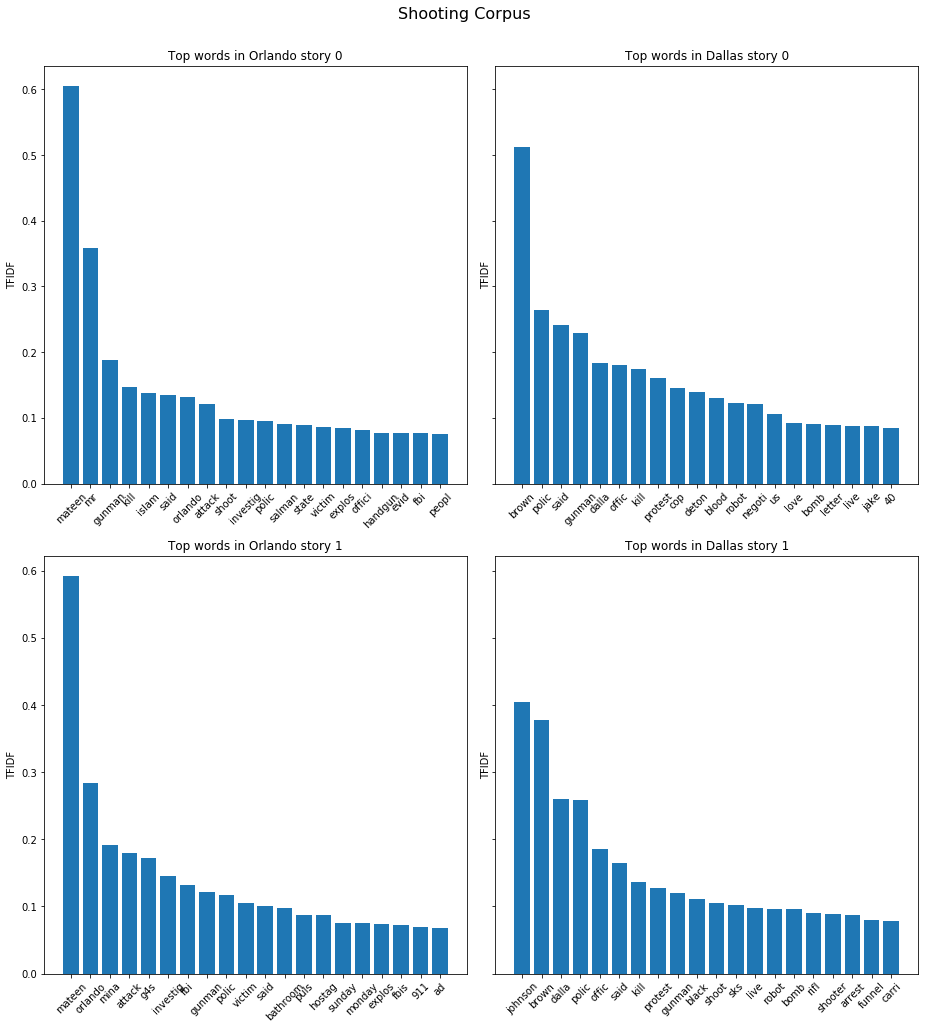

{20550: mateen      0.605630
 mr          0.359120
 gunman      0.187703
 kill        0.146889
 islam       0.137425
 said        0.135354
 orlando     0.131212
 attack      0.121727
 shoot       0.098610
 investig    0.097438
 polic       0.094459
 salman      0.089902
 state       0.089308
 victim      0.086333
 explos      0.085004
 offici      0.080815
 handgun     0.077070
 evid        0.076513
 fbi         0.076450
 peopl       0.075365
 Name: 4270, dtype: float64, 55912: brown      0.511639
 polic      0.263604
 said       0.241327
 gunman     0.229171
 dalla      0.184136
 offic      0.180765
 kill       0.173906
 protest    0.161143
 cop        0.145586
 deton      0.139344
 blood      0.130909
 robot      0.121963
 negoti     0.120957
 us         0.105734
 love       0.091671
 bomb       0.091103
 letter     0.089418
 live       0.088320
 jake       0.087775
 40         0.085138
 Name: 4299, dtype: float64, 169930: mateen      0.592654
 orlando     0.283963
 mina        0.192

In [50]:
get_plot_top_words(pd.concat([corpus_2016.sample(frac=0.05), stories_or, stories_dal]),
                   tokenize_stem, [orlando_sids, dallas_sids], verbose=True)

# fig, axarr = plt.subplots(nsids,2,sharey='row', figsize=(10,15))

# for i ,sid in enumerate(orlando_sids):
#     top_counts = get_top_words(corpus, sid, tokenizer=tokenizer, max_df=0.90, min_df=5)
#     ax = make_series_bar(axarr.flatten(order='F')[i], 
#                          series=top_counts, title='Top words in Orlando story {}'.format(i))
#     ax.set_ylabel('TFIDF')
    
# offset = len(orlando_sids)
# for i ,sid in enumerate(dallas_sids):
#     print('Get top words in story {}'.format(sid))
#     top_counts = get_top_words(corpus, sid, tokenizer=tokenizer, max_df=0.90, min_df=5)
#     ax = make_series_bar(axarr.flatten(order='F')[offset + i], 
#                          series=top_counts, title='Top words in Dallas story {}'.format(i))
#     ax.set_ylabel('TFIDF')

# # plt.savefig('compare_orlando_tfidf_scores.png')
# plt.suptitle('All 2016 Stories Corpus', fontsize=16)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()



To provide context here are what some words mean 
- mateen is the name of the man responsible for the orlando shooting
- g4s is the security company where he worked
- micah johnson was the name of the man responsible for the dallas shooting

Compare words in either or both camps and find a way to display that.

In [ ]:
# print(df[df.id == 55912].content.values[0])
# print(preprocess(df[df.id == 55912].content.values[0]))
# tokenize(preprocess(df[df.id == 55912].content.values[0]))

In [ ]:
lemmatizer.lemmatize('us') # laaaaaammmmee